In [ ]:
import easyocr as ocr
import depthai as dai
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

In [ ]:
# create a pipeline
pipeline = dai.Pipeline()
# create a color camera node
camRgb = pipeline.create(dai.node.ColorCamera)
# set the camera properties
camRgb.setBoardSocket(dai.CameraBoardSocket.CAM_A)
camRgb.setInterleaved(False)
camRgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
camRgb.initialControl.setManualExposure(
    2000, 800
)
camRgb.setFps(10.)

# create an output stream for the camera
xout = pipeline.createXLinkOut()
camRgb.video.link(xout.input)
xout.setStreamName("video")

# device
ip = "192.168.42.209"
device_settings = dai.DeviceInfo(ip)
device = dai.Device(pipeline, device_settings)
device.startPipeline()

In [ ]:
# get the video stream
video_queue = device.getOutputQueue("video", maxSize=1, blocking=False)

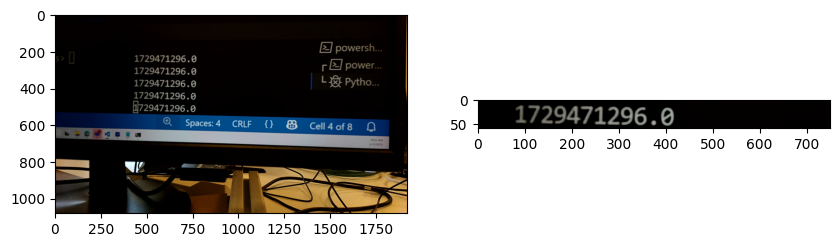

In [36]:
message = video_queue.get()
frame = cv2.cvtColor(message.getCvFrame(), cv2.COLOR_BGR2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(frame)
frame = frame[410:470, 350:1100]
ax2.imshow(frame)

In [37]:
# what text is in the frame?
reader = ocr.Reader(["en"], gpu=True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [38]:
estimated_latencies_ms = []
true_latencies_ms = []
for _ in range(200):
    message = video_queue.get()
    current_timestamp = dai.Clock.now()
    message_timestamp = message.getTimestamp()
    estimated_latency_ms = (current_timestamp - message_timestamp).total_seconds() * 1000

    real_time = time.monotonic_ns() / 1000000
    frame = cv2.cvtColor(message.getCvFrame(), cv2.COLOR_BGR2RGB)
    frame = frame[410:470, 350:1100]
    try:
        result = reader.readtext(frame)
        screen_time = float(result[0][1])
    except:
        print("No text found")
        continue
    
    true_latency_ms = real_time - screen_time
    estimated_latencies_ms.append(estimated_latency_ms)
    true_latencies_ms.append(true_latency_ms)

No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found
No text found


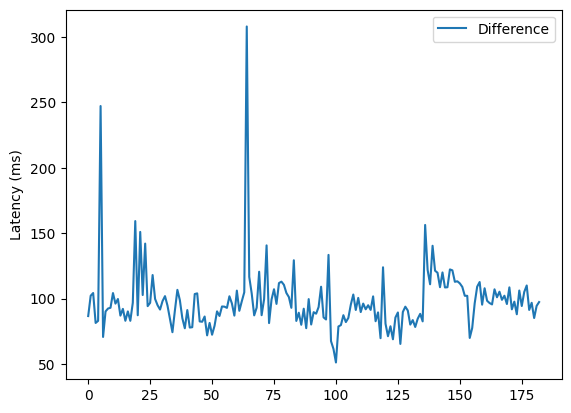

In [39]:
difference_ms = np.array(true_latencies_ms) - np.array(estimated_latencies_ms)
plt.plot(difference_ms, label="Difference")
plt.ylabel("Latency (ms)")
plt.legend()

In [40]:
median = np.median(difference_ms)
print(median)

94.487
